In [1]:
import numpy as np
import pandas as pd
import matplotlib
import cv2
import torchvision
import torch
from torch.autograd import Variable
from torch import Tensor, cat, sigmoid, exp, stack, max, meshgrid, linspace, arange
from model import Darknet, Tail, Head, Tails, Sequential

#from torch.nn import Conv2d
#from weight_formater import darknet, tail, we#ight, weights

In [2]:
darknet = Darknet()
tail = Tails(1, [3, 3, 3])

In [3]:
with open( "/home/ivan/sets/best_big/backup/v3single_last.weights", "rb") as f:
             header = np.fromfile(f, dtype=np.int32, count=5)
             seen = header[3]
             flatten_weights = np.fromfile(f, dtype=np.float32)

In [4]:
print(len(flatten_weights))

61576342


In [5]:
flatten_weights = darknet.load_weights(flatten_weights)

In [6]:
tail.load_weight(flatten_weights)

0


In [7]:
darknet.eval()
tail.eval()

Tails(
  (tails): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1)
        (6): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): LeakyReLU(negative_slope=0.1)
        (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(

In [8]:
number_of_classes = 1

In [9]:
len(flatten_weights)

20955702

In [10]:
image = cv2.imread("/home/ivan/Desktop/BN-UQ280_FEDUCI_GR_20170810142213.jpg")
image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_LINEAR)
img_ =  image[:,:,::-1].transpose((2,0,1))  # BGR -> RGB | H X W C -> C X H X W 
img_ = img_[np.newaxis,:,:,:]/255.0  
image_tensor = img_     
image_tensor = Variable(torch.from_numpy(image_tensor).float())
#image_tensor = image_tensor.permute(2, 0, 1)

In [11]:
head = Head(Tensor([[120, 93],  [84,191], [238,186]]),1)
anchors=Tensor([[120, 93],  [84,191], [238,186]]).view(3, 1, 1, 2)
head_1 = Head(Tensor([[22, 59],  [61, 43],  [50, 97]]),1)
anchors_1=Tensor([[22, 59],  [61, 43],  [50, 97]]).view(3, 1, 1, 2)
head_2 = Head(Tensor([[12, 25],  [23, 16],  [36, 26]]),1)
anchors_2 = Tensor([[12, 25],  [23, 16],  [36, 26]]).view(3, 1, 1, 2)

In [12]:
dark = tail(darknet(image_tensor))

In [13]:
features = dark[0]
features_1 = dark[1]
features_2 = dark[2]

In [ ]:
grid_size = list(features.size()[-2:])
cells_offsets = stack(meshgrid(((arange(0, grid_size[0]))/ 13.),
                               ((arange(0, grid_size[0]))/ 13.)), -1)[...,[1,0]]

grid_size_1 = list(features_1.size()[-2:])
cells_offsets_1 = stack(meshgrid(((arange(0, grid_size_1[0]))/ 26.),
                               ((arange(0, grid_size_1[0]))/ 26.)), -1)[...,[1,0]]

grid_size_2 = list(features_2.size()[-2:])
cells_offsets_2 = stack(meshgrid(((arange(0, grid_size_2[0]))/ 52.),
                               ((arange(0, grid_size_2[0]))/ 52.)), -1)[...,[1,0]]


In [ ]:
features = features.view([-1, len(anchors),number_of_classes + 5] + grid_size) \
        .permute(0, 1, 3, 4, 2) \
        .contiguous()
features_1 = features_1.view([-1, len(anchors), number_of_classes + 5] + grid_size_1) \
        .permute(0, 1, 3, 4, 2) \
        .contiguous()
features_2 = features_2.view([-1, len(anchors), number_of_classes + 5] + grid_size_2) \
        .permute(0, 1, 3, 4, 2) \
        .contiguous()

In [ ]:
centers = sigmoid(features[..., :2]) / Tensor(grid_size) + cells_offsets
sizes = exp(features[..., 2:4]) * anchors
probabilities = sigmoid(features[..., 4:])

centers_1 = sigmoid(features_1[..., :2]) / Tensor(grid_size_1) + cells_offsets_1
sizes_1 = exp(features_1[..., 2:4]) * anchors_1
probabilities_1 = sigmoid(features_1[..., 4:])

centers_2 = sigmoid(features_2[..., :2]) / Tensor(grid_size_2) + cells_offsets_2
sizes_2 = exp(features_2[..., 2:4]) * anchors_2
probabilities_2 = sigmoid(features_2[..., 4:])

In [14]:
centers, sizes, probabilities = head(features)

In [15]:
centers_1, sizes_1, probabilities_1 = head_1(features_1)

In [16]:
centers_2, sizes_2, probabilities_2 = head_2(features_2)

In [17]:
boxes = pd.DataFrame(centers.view(-1,2).detach().numpy() * 416, columns=["center_x","center_y"])
boxes["width"]=0
boxes['height']=0
boxes["obj"] = probabilities.view(-1,2)[...,0].detach().numpy()
boxes[["width","height"]] = sizes.view(-1,2).detach().numpy()
boxes["obj"].max()

boxes_1 = pd.DataFrame(centers_1.view(-1,2).detach().numpy() * 416, columns=["center_x","center_y"])
boxes_1["width"]=0
boxes_1['height']=0
boxes_1["obj"] = probabilities_1.view(-1,2)[...,0].detach().numpy()
boxes_1[["width","height"]] = sizes_1.view(-1,2).detach().numpy()
boxes_1["obj"].max()

boxes_2 = pd.DataFrame(centers_2.view(-1,2).detach().numpy() * 416, columns=["center_x","center_y"])
boxes_2["width"]=0
boxes_2['height']=0
boxes_2["obj"] = probabilities_2.view(-1,2)[...,0].detach().numpy()
boxes_2[["width","height"]] = sizes_2.view(-1,2).detach().numpy()
boxes_2["obj"].max()
boxes =boxes.append(boxes_1).append(boxes_2)

In [18]:
from src.boxes_manipulations import convert_to_matplotlib
import matplotlib.pyplot as plt

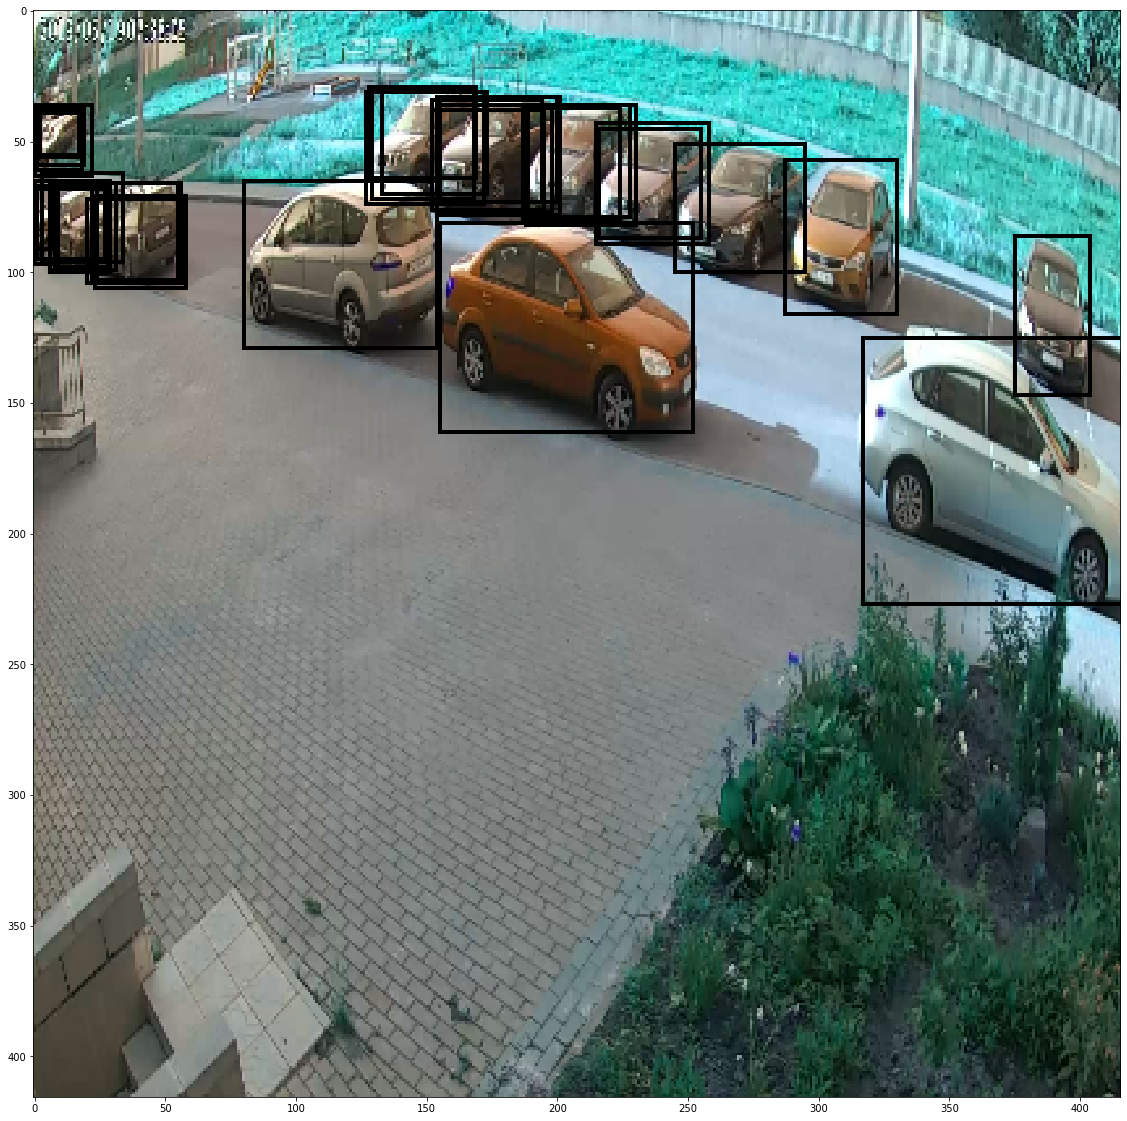

In [19]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
for x,y, w, h in boxes.loc[boxes["obj"]>0.1,["center_x", "center_y","width", "height"]].values:
       #ax.plot([x],[y],"r+", linewidth=9)
       ax.add_patch(plt.Rectangle((int(x-w/2), int(y-h/2)), int(w), int(h), linewidth=4, fill=False))
plt.imshow(image)
plt.show()

In [ ]:
grid_size = list(features_1.size()[-2:])
cells_offsets = stack(meshgrid(linspace(0, 1 - 1 / grid_size[0], grid_size[0]),
                                       linspace(0, 1 - 1 / grid_size[1], grid_size[1])), -1)[...,[1,0]]

In [ ]:
cells_offsets

In [ ]:
grid = np.arange(25)
a,b = np.meshgrid(grid, grid)

x_offset = torch.FloatTensor(a).view(-1,1)
y_offset = torch.FloatTensor(b).view(-1,1)
torch.cat((x_offset, y_offset), 1).unsqueeze(0)/26